### 코드 순서
- [1️⃣ Create deployment using 🦾 Bicep](#2)
- [🧪 직접 HTTP를 호출하여 API 테스트](#requests)
- [🔍 Load Balancing 결과 분석](#plot)

### 사전 준비 사항
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

<a id='1'></a>
### 1️⃣ 🦾 Bicep을 사용하여 API Management의 Backend Pool을 등록합니다.

이 단계에서는 [Bicep](https://learn.microsoft.com/en-us/azure/azure-resource-manager/bicep/overview?tabs=bicep)을 이용하여 Backend Pool을 등록합니다.
backend-pool.bicep의 변수들을 입력합니다.

In [ ]:
! az deployment group create --name backend-pool-deployment --resource-group {your-resource-grop}} --template-file "backend-pool.bicep"

<a id='requests'></a>
### 🧪 직접 HTTP를 호출하여 API 테스트
Request는 간단한 raw API request를 만들고 응답을 받아오는 Python용 HTTP 라이브러리입니다.

HTTP 429 응답코드는 보지 못할 것입니다. API Management의 `retry` policy가 가용한 backend를 선택할 것이고, 가용한 backend가 없다면 HTTP 503이 리턴 될 것입니다.

*Note: 아래 내용을 입력 한 후 실행하세요.
1. apim_resource_gateway_url: API Gateway URL
2. openai_depoyment_name: OpenAI deployment 이름 (예: gpt-4o)
3. openai_api_version: OpenAI API 버전 (예: 2024-02-01)

In [ ]:
import time
import requests
import json

runs = 10
sleep_time_ms = 0
url = "https://apim-jl-nov26.azure-api.net/openai-lb/deployments/gpt-4o/chat/completions?api-version=2024-02-01"
api_runs = []
apim_subscription_key = "{your-apim-subscription-key}"

for i in range(runs):
    print("▶️ Run:", i+1, "/", runs)
    

    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    
    start_time = time.time()
    response = requests.post(url, headers = {'Ocp-Apim-Subscription-Key':apim_subscription_key}, json = messages)
    response_time = time.time() - start_time
    
    print(f"⌚ {response_time:.2f} seconds")
    # Check the response status code and apply formatting
    if 200 <= response.status_code < 300:
        status_code_str = '\x1b[1;32m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and green
    elif response.status_code >= 400:
        status_code_str = '\x1b[1;31m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and red
    else:
        status_code_str = str(response.status_code)  # No formatting

    # Print the response status with the appropriate formatting
    print("Response status:", status_code_str)
    
    print("Response headers:", response.headers)
    
    if "x-ms-region" in response.headers:
        print("x-ms-region:", '\x1b[1;31m'+response.headers.get("x-ms-region")+'\x1b[0m') # this header is useful to determine the region of the backend that served the request
        api_runs.append((response_time, response.headers.get("x-ms-region")))
    
    if (response.status_code == 200):
        data = json.loads(response.text)
        print("Token usage:", data.get("usage"), "\n")
        print("💬 ", data.get("choices")[0].get("message").get("content"), "\n")
    else:
        print(response.text)   

    time.sleep(sleep_time_ms/1000)


▶️ Run: 1 / 10


MissingSchema: Invalid URL '{apim_resource_gateway_url}/openai-lb/deployments/{openai_deployment_name}/chat/completions?api-version={openai_api_version}': No scheme supplied. Perhaps you meant https://{apim_resource_gateway_url}/openai-lb/deployments/{openai_deployment_name}/chat/completions?api-version={openai_api_version}?

<a id='plot'></a>
### 🔍 Load Balancing 결과 분석


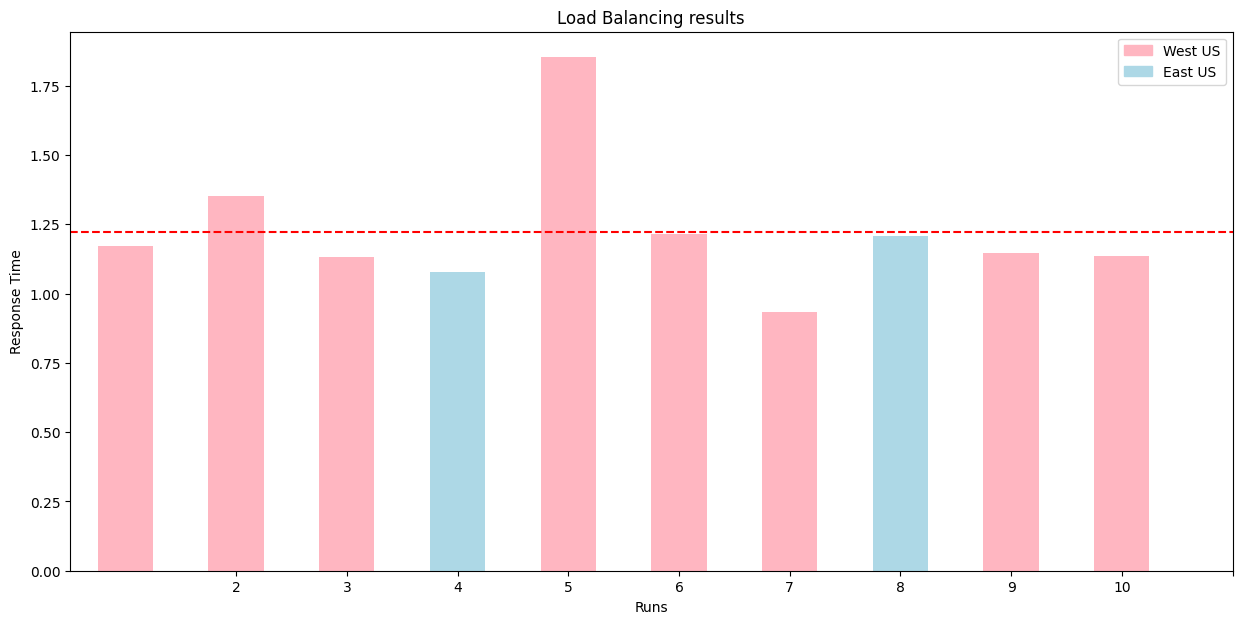

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'West US': 'lightpink', 'East US': 'lightblue'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind='bar', x='Run', y='Response Time', color=[color_map.get(region, 'gray') for region in df['Region']], legend=False)

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Runs')
plt.ylabel('Response Time')
plt.xticks(df['Run'], rotation=0)

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.show()